In [1]:
import nltk

In [2]:
# Set random seed
seed = 123
# Data manipulation/analysis
import re
import numpy as np
import pandas as pd
# Text preprocessing/analysis
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from scipy.sparse import hstack, csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
# Modelling
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
# Visualisation
from wordcloud import WordCloud , STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="whitegrid", context='talk')


In [3]:

PosNegFile = pd.read_csv('tweets_combined_edited.csv')
PosNegFile.head()


,tweet,sentiment
0,Today in Selfcare: beauty &amp; laughs Kung Fu...,positive
1,I get to spend New Year's home again alone and...,negative
2,"Depressed and lonely /: Stuck in a deep, never...",negative
3,If this is your response to someone saying the...,negative
4,Apparently you get a free pass just by mention...,positive


In [4]:


DepFile = pd.read_csv('depressedData_Edited.csv')
#print(f"{sample.shape[0]} rows and {sample.shape[1]} columns")
DepFile.head()

,Unnamed: 0,tweet,sentiment,new_tweets
0,0,just know what ur going through battle depress...,depressed,know ur go battle depression ptsd social anxie...
1,1,wow depression and anxiety really tryna come f...,depressed,wow depression anxiety really tryna come today...
2,2,you aint making joke about someones depression...,depressed,ai nt make joke someone depression injury bish...
3,3,why do insta meme pages post videos of naked w...,depressed,insta meme page post video naked woman ugly as...
4,4,cant handle school anymore but hate in person ...,depressed,ca nt handle school anymore hate person even t...


In [5]:
#looking at splits 1 for negative 0 for positive
PosNegFile['sentiment'].value_counts()

positive    2226
negative     974
Name: sentiment, dtype: int64

In [6]:
#looking at splits 1 for depressed 0 for not depressed
DepFile['sentiment'].value_counts()

depressed        16000
not depressed    15000
Name: sentiment, dtype: int64

In [7]:
# Select the ones you want
PNFile = PosNegFile[['tweet','sentiment']]

# Encode to numeric
PNFile['target'] = np.where(PosNegFile['sentiment']=='negative', 1, 0)
# Check values
PNFile.groupby(['sentiment', 'target']).count().unstack()

tweet       
target          0      1
sentiment               
negative      NaN  974.0
positive   2226.0    NaN

In [8]:
# Select the ones you want
DNDFile = DepFile[['new_tweets','sentiment']]

# Encode to numeric
DNDFile['target'] = np.where(DepFile['sentiment']=='depressed', 1, 0)
# Check values
DNDFile.groupby(['sentiment', 'target']).count().unstack()

<ipython-input-8-1e8ebd44fdf9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DNDFile['target'] = np.where(DepFile['sentiment']=='depressed', 1, 0)


new_tweets         
target                 0        1
sentiment                        
depressed            NaN  16000.0
not depressed    15000.0      NaN

In [9]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(PNFile['tweet'], PNFile['target'], test_size=639, random_state=seed)

trainPN = pd.concat([X_train1, y_train1], axis=1)
testPN = pd.concat([X_test1, y_test1], axis=1)

print(f"TrainPN: {trainPN.shape[0]} rows and {trainPN.shape[1]} columns")
print(f"{trainPN['target'].value_counts()}\n")
print(f"TestPN: {testPN.shape[0]} rows and {testPN.shape[1]} columns")
print(testPN['target'].value_counts())

TrainPN: 2561 rows and 2 columns
0    1787
1     774
Name: target, dtype: int64

TestPN: 639 rows and 2 columns
0    439
1    200
Name: target, dtype: int64


In [10]:
X_train, X_test, y_train, y_test = train_test_split(DNDFile['new_tweets'], DNDFile['target'], test_size=6200, random_state=seed)

traindep = pd.concat([X_train, y_train], axis=1)
testdep = pd.concat([X_test, y_test], axis=1)

print(f"Traindep: {traindep.shape[0]} rows and {traindep.shape[1]} columns")
print(f"{traindep['target'].value_counts()}\n")
print(f"Testdep: {testdep.shape[0]} rows and {testdep.shape[1]} columns")
print(testdep['target'].value_counts())

Traindep: 24800 rows and 2 columns
1    12825
0    11975
Name: target, dtype: int64

Testdep: 6200 rows and 2 columns
1    3175
0    3025
Name: target, dtype: int64


In [11]:
trainPN.head(15)

,tweet,target
384,128 ????????????????????????????????????? ??...,0
697,@DaddysLittleK Wow I've just spotted the cutes...,0
190,Going to have to say goodbye to our beloved pu...,1
1332,Give up now on the one I like and I'll regret ...,0
1582,Believing in yourself is key in attaining what...,0
153,Then daddy wanna call talking bout wake up and...,0
759,"Reminder: Our office is closed tomorrow, Thurs...",0
3047,Medication doesn't teach people how to feel b...,0
419,I made this account so that I wouldn't be judg...,1
1208,slowly your heart peeled off itself...,0


In [12]:
testPN.head(15)

,tweet,target
846,Small Ceramic Ashtrays for Cigars pic.twitter...,0
2589,"I would never kill myself, but I don't think I...",1
1837,This is my stance.... pic.twitter.com/YI7vjf...,0
2900,@ggreenwald Macron slips up and has a moment o...,0
547,When the water is boiling add in the spagetti,0
305,In the gym trying to clear my mind.,0
1233,@annie_hawthorne Just one? 😄 Cress and Thorne...,0
2143,@shahidafridi37 at his best.... Great to watch...,0
601,Share your #smile today!,0
2244,@nytimes @pattonoswalt I am so happy that you ...,0


In [13]:
traindep.head(15)

,new_tweets,target
4740,okay stress everything stress right sleep well...,1
12041,tw abuse depression I m like trigger taylor sh...,1
9417,literally useless today heatwave soul drown hu...,1
2360,furlough part year give chance think work life...,1
3917,believe depression anxiety ever prevalent cons...,1
12793,whole life build wall get hurt people imprison...,1
5405,verge pass office exhaust lack sleep help want...,1
18851,call current situation struggle take far let f...,0
29847,maybe never concert game time event think retu...,0
21748,know mile away get car piss let go lol,0


In [14]:
testdep.head(15)

,new_tweets,target
22744,I m happy without much fuss live lifestyle I m...,0
14022,absolutely hate mask whole idea work horrify s...,1
120,joshpeck exercisingpotato sandmandaddy indicat...,1
4772,want cry feel chest want die young momma know ...,1
9688,culinary class today classmate tell god tired ...,1
5100,want cry idk bc andre come bc breathe stress,1
29216,bonus use malthusian first time hear use brave...,0
1221,fuck god damn clown fool depression real treat...,1
24005,night senate session pass relief bill nope nig...,0
4842,day see ongniel photo wanna cry cus want free ...,1


In [15]:
sid = SentimentIntensityAnalyzer()

In [16]:
trainPN[['pos', 'neu', 'neg', 'compound']] = trainPN['tweet'].apply(sid.polarity_scores).apply(pd.Series)
trainPN.head(15)

,tweet,target,pos,neu,neg,compound
384,128 ????????????????????????????????????? ??...,0,0.000,1.000,0.000,0.0000
697,@DaddysLittleK Wow I've just spotted the cutes...,0,0.000,0.440,0.560,0.8807
190,Going to have to say goodbye to our beloved pu...,1,0.000,0.798,0.202,0.5106
1332,Give up now on the one I like and I'll regret ...,0,0.145,0.725,0.130,-0.0772
1582,Believing in yourself is key in attaining what...,0,0.000,0.925,0.075,0.0772
153,Then daddy wanna call talking bout wake up and...,0,0.321,0.679,0.000,-0.6369
759,"Reminder: Our office is closed tomorrow, Thurs...",0,0.000,1.000,0.000,0.0000
3047,Medication doesn't teach people how to feel b...,0,0.000,0.756,0.244,0.7003
419,I made this account so that I wouldn't be judg...,1,0.095,0.905,0.000,-0.2755
1208,slowly your heart peeled off itself...,0,0.000,1.000,0.000,0.0000


In [17]:
traindep[['dep', 'neu', 'nondep', 'compound']] = traindep['new_tweets'].apply(sid.polarity_scores).apply(pd.Series)
traindep = traindep[['new_tweets','target','dep','nondep','compound']]
traindep.head(15)

,new_tweets,target,dep,nondep,compound
4740,okay stress everything stress right sleep well...,1,0.458,0.279,-0.6597
12041,tw abuse depression I m like trigger taylor sh...,1,0.479,0.205,-0.9081
9417,literally useless today heatwave soul drown hu...,1,0.376,0.087,-0.8658
2360,furlough part year give chance think work life...,1,0.295,0.067,-0.7783
3917,believe depression anxiety ever prevalent cons...,1,0.568,0.000,-0.9337
12793,whole life build wall get hurt people imprison...,1,0.501,0.000,-0.9590
5405,verge pass office exhaust lack sleep help want...,1,0.571,0.172,-0.8519
18851,call current situation struggle take far let f...,0,0.167,0.216,0.2263
29847,maybe never concert game time event think retu...,0,0.000,0.363,0.6908
21748,know mile away get car piss let go lol,0,0.216,0.224,0.0258


In [18]:
PosNegFile.head()

,tweet,sentiment
0,Today in Selfcare: beauty &amp; laughs Kung Fu...,positive
1,I get to spend New Year's home again alone and...,negative
2,"Depressed and lonely /: Stuck in a deep, never...",negative
3,If this is your response to someone saying the...,negative
4,Apparently you get a free pass just by mention...,positive


In [19]:
# split df - positive and negative sentiment:
positive = trainPN[trainPN['target'] == 0]
negative = trainPN[trainPN['target'] == 1]

In [20]:
positive.head()

,tweet,target,pos,neu,neg,compound
384,128 ????????????????????????????????????? ??...,0,0.000,1.000,0.000,0.0000
697,@DaddysLittleK Wow I've just spotted the cutes...,0,0.000,0.440,0.560,0.8807
1332,Give up now on the one I like and I'll regret ...,0,0.145,0.725,0.130,-0.0772
1582,Believing in yourself is key in attaining what...,0,0.000,0.925,0.075,0.0772
153,Then daddy wanna call talking bout wake up and...,0,0.321,0.679,0.000,-0.6369


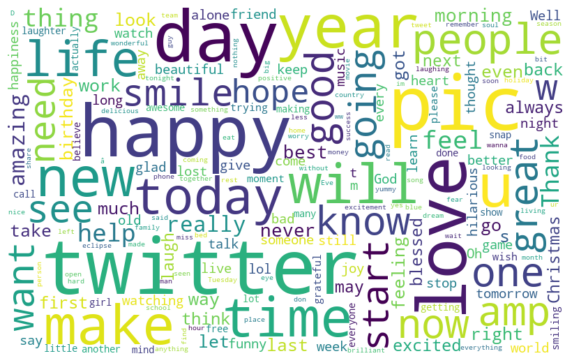

In [21]:
#wordcloud positive

stopwords = set(STOPWORDS)
stopwords.update(["br", "href","n"]) 
## good and great removed because they were included in negative sentiment
pos = " ".join(review for review in positive.tweet)
wordcloud2 = WordCloud(width=800, height=500, random_state=21, max_font_size=110, stopwords=stopwords,background_color="white",collocations=False).generate(pos)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud2, interpolation="bilinear")
plt.axis('off')
plt.show()

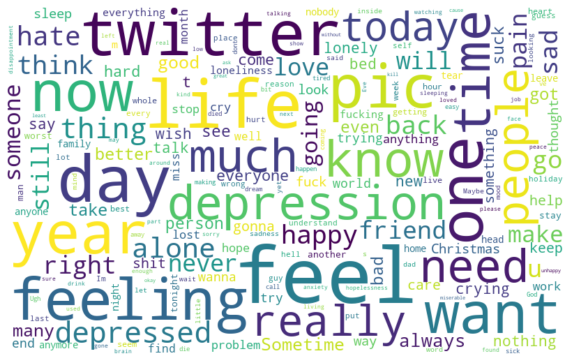

In [22]:
#wordcloud negative

stopwords = set(STOPWORDS)
stopwords.update(["br", "href","n"]) 
## good and great removed because they were included in negative sentiment
neg = " ".join(review for review in negative.tweet)
wordcloud3 = WordCloud(width=800, height=500, random_state=21, max_font_size=110, stopwords=stopwords,background_color="white",collocations=False).generate(neg)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud3, interpolation="bilinear")
plt.axis('off')
plt.show()

In [23]:
# split df - depressed and not depressed sentiment:
not_depressed = traindep[traindep['target'] == 0]
depressed = traindep[traindep['target'] == 1]

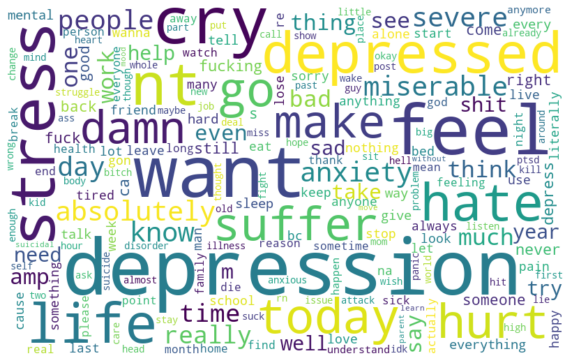

In [24]:
#wordcloud depressed

stopwords = set(STOPWORDS)
stopwords.update(["br", "href","n"]) 
## good and great removed because they were included in negative sentiment
dep = " ".join(review for review in depressed.new_tweets)
wordcloud4 = WordCloud(width=800, height=500, random_state=21, max_font_size=110, stopwords=stopwords,background_color="white",collocations=False).generate(dep)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud4, interpolation="bilinear")
plt.axis('off')
plt.show()

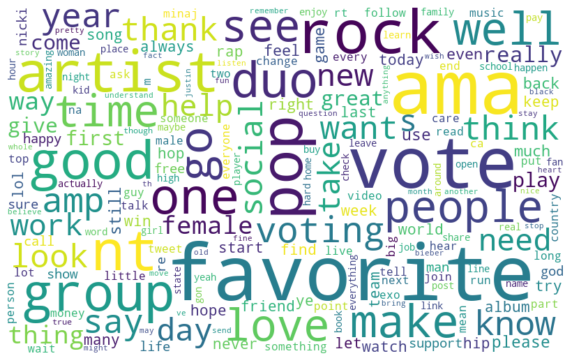

In [25]:
#wordcloud not depressed

stopwords = set(STOPWORDS)
stopwords.update(["br", "href","n","bt","bts"]) 
## good and great removed because they were included in negative sentiment
not_dep = " ".join(review for review in not_depressed.new_tweets)
wordcloud4 = WordCloud(width=800, height=500, random_state=21, max_font_size=110, stopwords=stopwords,background_color="white",collocations=False).generate(not_dep)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud4, interpolation="bilinear")
plt.axis('off')
plt.show()

In [26]:
trainPN['vader_polarity'] = np.where(trainPN['pos']>trainPN['neg'], 0, 1)
target_names=['negative', 'positive']
print(classification_report(trainPN['target'], 
                            trainPN['vader_polarity'], 
                            target_names=target_names))

              precision    recall  f1-score   support

    negative       0.47      0.22      0.30      1787
    positive       0.20      0.44      0.27       774

    accuracy                           0.28      2561
   macro avg       0.33      0.33      0.28      2561
weighted avg       0.39      0.28      0.29      2561



In [27]:
traindep['vader_polarity'] = np.where(traindep['dep']>traindep['nondep'], 1, 0)
target_names1=['depressed', 'not depressed']
print(classification_report(traindep['target'], 
                            traindep['vader_polarity'], 
                            target_names=target_names1))

               precision    recall  f1-score   support

    depressed       0.95      0.95      0.95     11975
not depressed       0.96      0.95      0.95     12825

     accuracy                           0.95     24800
    macro avg       0.95      0.95      0.95     24800
 weighted avg       0.95      0.95      0.95     24800



In [28]:
#because PNTrain is not eligible we will try a new analyzer
#polarity: ranges from -1 (the most negative) to 1 (the most positive)
#subjectivity: ranges from 0 (very objective) to 1 (very subjective)
#we dont need subjectivity because all tweets are subjective

trainPN[['polarity', 'subjectivity']] = trainPN['tweet'].apply(lambda x:TextBlob(x).sentiment).to_list()
columns = ['tweet', 'target', 'polarity', 'subjectivity']
trainPN[columns].nlargest(5, ['polarity'])

,tweet,target,polarity,subjectivity
1074,@Hayles_101 Delaney keeping up his awesome Man...,0,1.0,1.000
1889,@MarcMero Happy Anniversary!! Have a great day!!,0,1.0,0.875
58,One of my best friends got engaged ????,0,1.0,0.300
518,@m00nlightjules happy birthday mamon!!! 😄,0,1.0,1.000
502,@billjoehughes Sounds delightful 😅,0,1.0,1.000


In [29]:
trainPN[columns].nsmallest(5, ['polarity'])

,tweet,target,polarity,subjectivity
2826,This month has had to be the worst month out o...,1,-1.0,1.0
477,"is a garment of heaviness, another evil devic...",0,-1.0,1.0
906,How come theres no support or advice for peopl...,0,-1.0,1.0
2055,"Have you ever felt so and , that you had horr...",1,-1.0,1.0
152,"""I used to think that the worst thing in life ...",1,-1.0,1.0


In [30]:
trainPN['blob_polarity'] = np.where(trainPN['polarity']>0, 1, 0)
print(classification_report(trainPN['target'], 
                            trainPN['blob_polarity'], 
                            target_names=target_names))

              precision    recall  f1-score   support

    negative       0.62      0.46      0.53      1787
    positive       0.22      0.35      0.27       774

    accuracy                           0.43      2561
   macro avg       0.42      0.41      0.40      2561
weighted avg       0.50      0.43      0.45      2561



In [31]:
pd.crosstab(trainPN['vader_polarity'], trainPN['blob_polarity'])

blob_polarity,0,1
vader_polarity,,
0,584,231
1,746,1000


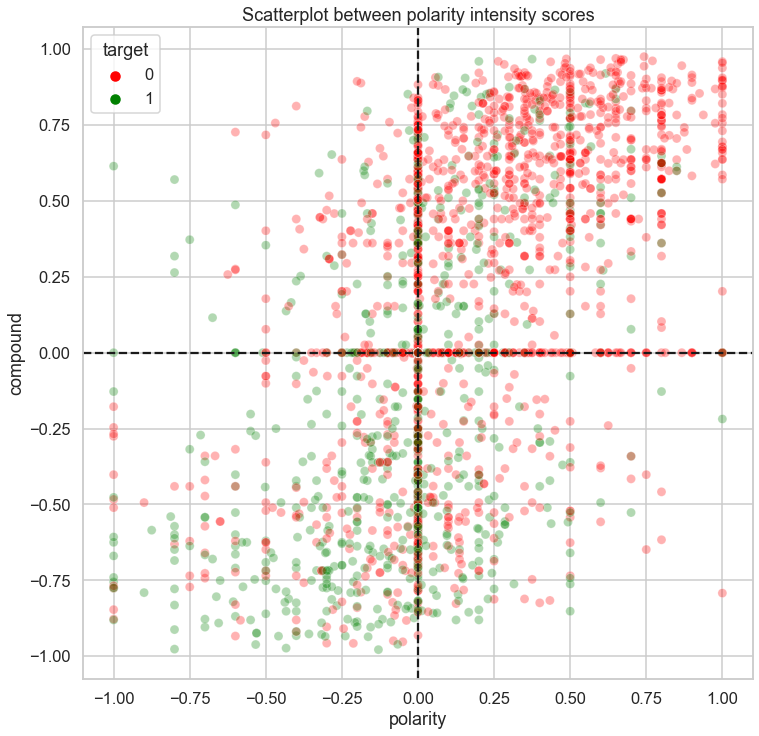

In [32]:
plt.figure(figsize=(12,12))
sns.scatterplot(data=trainPN, x='polarity', y='compound',
                hue='target', palette=['red', 'green'], 
                alpha=.3)
plt.axhline(0, linestyle='--', color='k')
plt.axvline(0, linestyle='--', color='k')
plt.title('Scatterplot between polarity intensity scores');

In [33]:
# Define functions
def create_baseline_models():
    """Create list of baseline models."""
    models = []
    models.append(('log', LogisticRegression(random_state=seed, 
                                             max_iter=1000)))
    models.append(('sgd', SGDClassifier(random_state=seed)))
    models.append(('mnb', MultinomialNB()))
    return models
def assess(X, y, models, cv=5, scoring=['roc_auc', 
                                        'accuracy', 
                                        'f1']):
    """Provide summary of cross validation results for models."""
    results = pd.DataFrame()
    for name, model in models:
        result = pd.DataFrame(cross_validate(model, X, y, cv=cv, 
                                             scoring=scoring))
        mean = result.mean().rename('{}_mean'.format)
        std = result.std().rename('{}_std'.format)
        results[name] = pd.concat([mean, std], axis=0)
    return results.sort_index()

In [34]:
models = create_baseline_models()
models

[('log', LogisticRegression(max_iter=1000, random_state=123)),
 ('sgd', SGDClassifier(random_state=123)),
 ('mnb', MultinomialNB())]

In [35]:
#this machine is for dep and not dep

# Preprocess the data
vectoriser = TfidfVectorizer(token_pattern=r'[a-z]+', 
                             stop_words='english', 
                             min_df=30, 
                             max_df=.7)
X_train_simpler = vectoriser.fit_transform(X_train)
# Assess the model
assess(X_train_simpler, y_train, models)

,log,sgd,mnb
fit_time_mean,0.145913,0.022989,0.007397
fit_time_std,0.027554,0.002336,0.000551
score_time_mean,0.006196,0.006194,0.007391
score_time_std,0.000447,0.000448,0.000551
test_accuracy_mean,0.994435,0.996573,0.913427
test_accuracy_std,0.000526,0.000946,0.003399
test_f1_mean,0.994628,0.996692,0.922330
test_f1_std,0.000506,0.000911,0.002696
test_roc_auc_mean,0.999571,0.999687,0.994334
test_roc_auc_std,0.000179,0.000142,0.000581


In [36]:
print(X_train_simpler)

  (0, 1351)	0.18537680538863588
  (0, 561)	0.47214942888385314
  (0, 249)	0.47929760380187153
  (0, 1128)	0.3350249535794361
  (0, 1034)	0.2958831084721543
  (0, 1192)	0.41367274108287644
  (0, 842)	0.3769223974550608
  (1, 1122)	0.27787402861686894
  (1, 601)	0.16185378743462528
  (1, 854)	0.34218080843286114
  (1, 1174)	0.25395904032437877
  (1, 287)	0.31082122481081187
  (1, 901)	0.29513912483613153
  (1, 496)	0.20910384249311934
  (1, 736)	0.14907312840244324
  (1, 1236)	0.2899629356001195
  (1, 1298)	0.30311440598271866
  (1, 695)	0.13041023289878972
  (1, 731)	0.19770347758084597
  (1, 328)	0.23599006650545667
  (1, 5)	0.31082122481081187
  (1, 1307)	0.2845888933558866
  (2, 459)	0.14899448668196852
  (2, 1081)	0.29898552961640223
  (2, 776)	0.19201044143595658
  :	:
  (24797, 932)	0.49802207223308886
  (24797, 1153)	0.48934196072120784
  (24797, 122)	0.46946917746179107
  (24797, 40)	0.22496972499608522
  (24797, 454)	0.22303305011789676
  (24797, 1342)	0.2371507493500186
  (247

In [46]:
x = pd.DataFrame(X_train_simpler, columns=[ 'vectorized'])

In [47]:
x.head()

,vectorized
0,"(0, 1351)\t0.18537680538863588\n (0, 561)\t..."
1,"(0, 1122)\t0.27787402861686894\n (0, 601)\t..."
2,"(0, 459)\t0.14899448668196852\n (0, 1081)\t..."
3,"(0, 990)\t0.20026279108454817\n (0, 828)\t0..."
4,"(0, 610)\t0.29475803237626136\n (0, 337)\t0..."


In [48]:
x.to_csv("depressed and not depressed vectorized statements.csv")

In [40]:
#this machine is for posneg

# Preprocess the data
vectoriser = TfidfVectorizer(token_pattern=r'[a-z]+', 
                             stop_words='english', 
                             min_df=30, 
                             max_df=.7)
X_train_simpler1 = vectoriser.fit_transform(X_train1)
# Assess the model
assess(X_train_simpler1, y_train1, models)

,log,sgd,mnb
fit_time_mean,0.024584,0.006396,0.001799
fit_time_std,0.002299,0.001140,0.000447
score_time_mean,0.003198,0.003017,0.002597
score_time_std,0.000447,0.000044,0.000546
test_accuracy_mean,0.751665,0.753614,0.744242
test_accuracy_std,0.011990,0.012712,0.010743
test_f1_mean,0.453751,0.469487,0.360030
test_f1_std,0.030490,0.031855,0.054289
test_roc_auc_mean,0.750058,0.739397,0.737709
test_roc_auc_std,0.029511,0.027067,0.025769


In [41]:
#this machine is for cleaned posneg 

# Define function
def preprocess_text(text):
    # 1. Tokenise to alphabetic tokens
    tokeniser = RegexpTokenizer(r'[A-Za-z]+')
    tokens = tokeniser.tokenize(text)
    
    # 2. Lowercase and lemmatise 
    lemmatiser = WordNetLemmatizer()
    tokens = [lemmatiser.lemmatize(t.lower(), pos='v') 
              for t in tokens]
    return tokens
# Preprocess the data
vectoriser = TfidfVectorizer(analyzer=preprocess_text, 
                             min_df=30, 
                             max_df=.7)
X_train_simple = vectoriser.fit_transform(X_train1)
# Assess models
assess(X_train_simple, y_train1, models)

,log,sgd,mnb
fit_time_mean,0.025232,8.394575e-03,1.999092e-03
fit_time_std,0.001949,1.516088e-03,1.994753e-07
score_time_mean,0.002798,2.999020e-03,1.998568e-03
score_time_std,0.000447,5.168792e-07,3.989506e-07
test_accuracy_mean,0.764161,7.586927e-01,7.450247e-01
test_accuracy_std,0.010617,9.959392e-03,1.046972e-02
test_f1_mean,0.501359,5.562424e-01,3.409514e-01
test_f1_std,0.034924,3.987443e-02,4.868838e-02
test_roc_auc_mean,0.801826,7.914916e-01,7.947427e-01
test_roc_auc_std,0.017183,1.811983e-02,1.639408e-02


In [43]:
print(X_train_simple)

  (0, 30)	0.582395312959625
  (0, 172)	0.5702990244367228
  (0, 130)	0.5792881167167013
  (1, 23)	0.6163811596484121
  (1, 17)	0.2230988437647358
  (1, 156)	0.25805937186597955
  (1, 81)	0.40690086441304724
  (1, 177)	0.530626947414193
  (1, 75)	0.2378513438079817
  (2, 77)	0.2545867983376796
  (2, 124)	0.46314736969641224
  (2, 136)	0.4269426539599133
  (2, 66)	0.26549729145622425
  (2, 167)	0.5637379633607406
  (2, 58)	0.33381867419944933
  (2, 156)	0.19666172971919355
  (3, 88)	0.2761771239602827
  (3, 105)	0.19056982648995438
  (3, 117)	0.19011578966746764
  (3, 79)	0.18996509338186826
  (3, 91)	0.3499061320630717
  (3, 10)	0.1659679252743712
  (3, 89)	0.2597754328751513
  (3, 120)	0.2837552002597189
  (3, 119)	0.2367629842980665
  :	:
  (2557, 143)	0.26037061007964474
  (2557, 34)	0.27030358778713964
  (2557, 100)	0.2825177220898246
  (2557, 76)	0.21289356023933972
  (2557, 160)	0.24401826792127917
  (2557, 150)	0.15694342430217223
  (2557, 199)	0.7029151255983949
  (2557, 10)	0.1

In [49]:
y = pd.DataFrame(X_train_simple, columns=[ 'vectorized'])

In [50]:
y.to_csv("pos and neg vectorized statements.csv")

In [ ]:
plt.figure(figsize = (14,5))
columns = ['target', 'neg', 'neu', 'pos', 'compound', 'polarity', 
           'subjectivity']
sns.heatmap(trainPN[columns].corr(), annot=True, cmap='seismic_r');

In [ ]:
# Create a pipeline
pipe = Pipeline([('vectoriser', TfidfVectorizer(token_pattern=r'[a-z]+')),
                 ('model', SGDClassifier(random_state=seed))])
# Prepare a random search
param_distributions = {'vectoriser__min_df': np.arange(10, 1000, 10),
                       'vectoriser__max_df': np.linspace(.2, 1, 40),
                       'model__loss': ['log', 'hinge']}
r_search = RandomizedSearchCV(estimator=pipe, param_distributions=param_distributions, 
                              n_iter=30, cv=5, n_jobs=-1, random_state=seed)
r_search.fit(X_train1, y_train1)
# Save results to a dataframe
r_search_results = pd.DataFrame(r_search.cv_results_).sort_values(by='rank_test_score')

In [ ]:
columns = [col for col in r_search_results.columns 
           if re.search(r"split|param_", col)]
r_summary = r_search_results[columns].copy()
r_summary.columns = [re.sub(r'_test_score|param_', '', col) 
                     for col in r_summary.columns]
columns = [col.split('__')[1] if '__' in col else col 
           for col in r_summary.columns ]
r_summary.columns = columns
r_summary.head()

In [ ]:
# Create a pipeline
pipe = Pipeline([('vectoriser', TfidfVectorizer(token_pattern=r'[a-z]+', max_df=.6)),
                 ('model', SGDClassifier(random_state=seed, loss='log'))])
# Prepare a grid search
param_grid = {'vectoriser__min_df': [30, 90, 150],
              'vectoriser__ngram_range': [(1,1), (1,2)],
              'vectoriser__stop_words': [None, 'english'],
              'model__fit_intercept': [True, False]}
g_search = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=5, n_jobs=-1)
g_search.fit(X_train1, y_train1)
# Save results to a dataframe
g_search_results = pd.DataFrame(g_search.cv_results_).sort_values(by='rank_test_score')

In [ ]:
columns = [col for col in g_search_results.columns 
           if re.search(r"split|param_", col)]
g_summary = g_search_results[columns+['mean_test_score']].copy()
g_summary.columns = [re.sub(r'_test_score|param_', '', col) 
                     for col in g_summary.columns]
columns = [col.split('__')[1] if '__' in col else col 
           for col in g_summary.columns ]
g_summary.columns = columns
g_summary.head()

In [ ]:
pipe = Pipeline([('vectoriser', TfidfVectorizer(token_pattern=r'[a-z]+', min_df=30, max_df=.6, ngram_range=(1,2))),
                 ('model', SGDClassifier(random_state=seed, loss='log'))])
pipe.fit(X_train1, y_train1)


In [ ]:
coefs = pd.DataFrame(pipe['model'].coef_, 
                     columns=pipe['vectoriser'].get_feature_names())
coefs = coefs.T.rename(columns={0:'coef'}).sort_values('coef')
coefs

In [ ]:
coefs.to_csv("coefficientPN.csv")

In [ ]:
train_pred = pipe.predict(X_train1)
print(classification_report(train_pred, 
                            y_train1, 
                            target_names=target_names))

In [ ]:
# Create function so that we could reuse later
def plot_cm(y_test, y_pred, target_names=['negative', 'positive'], 
            figsize=(5,3)):
    """Create a labelled confusion matrix plot."""
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt='g', cmap='BuGn', cbar=False, 
                ax=ax)
    ax.set_title('Confusion matrix')
    ax.set_xlabel('Predicted')
    ax.set_xticklabels(target_names)
    ax.set_ylabel('Actual')
    ax.set_yticklabels(target_names, 
                       fontdict={'verticalalignment': 'center'});
    
plot_cm(train_pred, y_train1, target_names=target_names)

In [ ]:
test_pred = pipe.predict(X_test1)
print(classification_report(test_pred, 
                            y_test1, 
                            target_names=target_names))

In [ ]:
plot_cm(test_pred, y_test1, target_names=target_names)

In [ ]:
# Create a pipeline
pipe = Pipeline([('vectoriser', TfidfVectorizer(token_pattern=r'[a-z]+')),
                 ('model', SGDClassifier(random_state=seed))])
# Prepare a random search
param_distributions = {'vectoriser__min_df': np.arange(10, 1000, 10),
                       'vectoriser__max_df': np.linspace(.2, 1, 40),
                       'model__loss': ['log', 'hinge']}
r_search = RandomizedSearchCV(estimator=pipe, param_distributions=param_distributions, 
                              n_iter=30, cv=5, n_jobs=-1, random_state=seed)
r_search.fit(X_train, y_train)
# Save results to a dataframe
r_search_results = pd.DataFrame(r_search.cv_results_).sort_values(by='rank_test_score')

In [ ]:
columns = [col for col in r_search_results.columns 
           if re.search(r"split|param_", col)]
r_summary = r_search_results[columns].copy()
r_summary.columns = [re.sub(r'_test_score|param_', '', col) 
                     for col in r_summary.columns]
columns = [col.split('__')[1] if '__' in col else col 
           for col in r_summary.columns ]
r_summary.columns = columns
r_summary.head()

In [ ]:
# Create a pipeline
pipe = Pipeline([('vectoriser', TfidfVectorizer(token_pattern=r'[a-z]+', max_df=.6)),
                 ('model', SGDClassifier(random_state=seed, loss='hinge'))])
# Prepare a grid search
param_grid = {'vectoriser__min_df': [30, 90, 150],
              'vectoriser__ngram_range': [(1,1), (1,2)],
              'vectoriser__stop_words': [None, 'english'],
              'model__fit_intercept': [True, False]}
g_search = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=5, n_jobs=-1)
g_search.fit(X_train, y_train)
# Save results to a dataframe
g_search_results = pd.DataFrame(g_search.cv_results_).sort_values(by='rank_test_score')

In [ ]:
columns = [col for col in g_search_results.columns 
           if re.search(r"split|param_", col)]
g_summary = g_search_results[columns+['mean_test_score']].copy()
g_summary.columns = [re.sub(r'_test_score|param_', '', col) 
                     for col in g_summary.columns]
columns = [col.split('__')[1] if '__' in col else col 
           for col in g_summary.columns ]
g_summary.columns = columns
g_summary.head()

In [ ]:
pipe = Pipeline([('vectoriser', TfidfVectorizer(token_pattern=r'[a-z]+', min_df=30, max_df=.6, ngram_range=(1,2))),
                 ('model', SGDClassifier(random_state=seed, loss='hinge'))])
pipe.fit(X_train, y_train)

In [ ]:
coefs = pd.DataFrame(pipe['model'].coef_, 
                     columns=pipe['vectoriser'].get_feature_names())
coefs = coefs.T.rename(columns={0:'coef'}).sort_values('coef')
coefs

In [ ]:
coefs.to_csv("coefficientDND.csv")

In [ ]:
train_pred = pipe.predict(X_train)
print(classification_report(train_pred, 
                            y_train, 
                            target_names=target_names))

In [ ]:
plot_cm(train_pred, y_train, target_names=target_names1)

In [ ]:
test_pred = pipe.predict(X_test)
print(classification_report(test_pred, 
                            y_test, 
                            target_names=target_names))

In [ ]:
plot_cm(test_pred, y_test, target_names=target_names1)